In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import math
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.preprocessing import scale


In [3]:
file = os.getcwd()+"/../data/029720-99999_allYrs_Avg.txt"
dat = pd.read_csv(file,header=None,names=["lat", "lon", "elevation","date","dir","spd","gus","temp","slp"])
dat.head()

,lat,lon,elevation,date,dir,spd,gus,temp,slp
0,60.514,22.263,49.1,19020101,2.199135,23.700998,***,30.200000,994.28
1,60.514,22.263,49.1,19020102,2.443461,6.800000,***,17.200000,993.96
2,60.514,22.263,49.1,19020103,2.208953,9.938701,***,-0.200000,1005.08
3,60.514,22.263,49.1,19020104,3.949456,23.453623,***,28.733333,985.386666667
4,60.514,22.263,49.1,19020105,4.417350,5.170652,***,30.466667,978.293333333


In [4]:
#switch date to datetime object
dat['date'] = pd.to_datetime(dat['date'],format = '%Y%m%d')
dat.head()

,lat,lon,elevation,date,dir,spd,gus,temp,slp
0,60.514,22.263,49.1,1902-01-01,2.199135,23.700998,***,30.200000,994.28
1,60.514,22.263,49.1,1902-01-02,2.443461,6.800000,***,17.200000,993.96
2,60.514,22.263,49.1,1902-01-03,2.208953,9.938701,***,-0.200000,1005.08
3,60.514,22.263,49.1,1902-01-04,3.949456,23.453623,***,28.733333,985.386666667
4,60.514,22.263,49.1,1902-01-05,4.417350,5.170652,***,30.466667,978.293333333


In [5]:
#Add more date columns for specific analyses
dat['year'] = pd.DatetimeIndex(dat['date']).year
dat['month'] = pd.DatetimeIndex(dat['date']).month
dat['day'] = pd.DatetimeIndex(dat['date']).day
dat['dayOfYear'] = pd.DatetimeIndex(dat['date']).dayofyear
dat['dir']=dat['dir']*(180/math.pi)


#Replace *** with NaN's 
dat = dat.replace('***',np.nan)
dat.head()

,lat,lon,elevation,date,dir,spd,gus,temp,slp,year,month,day,dayOfYear
0,60.514,22.263,49.1,1902-01-01,126.001139,23.700998,NaN,30.200000,994.28,1902,1,1,1
1,60.514,22.263,49.1,1902-01-02,140.000000,6.800000,NaN,17.200000,993.96,1902,1,2,2
2,60.514,22.263,49.1,1902-01-03,126.563681,9.938701,NaN,-0.200000,1005.08,1902,1,3,3
3,60.514,22.263,49.1,1902-01-04,226.287188,23.453623,NaN,28.733333,985.386666667,1902,1,4,4
4,60.514,22.263,49.1,1902-01-05,253.095503,5.170652,NaN,30.466667,978.293333333,1902,1,5,5


In [6]:
#As a horrible person, I'm going to assume there are always 365 days in a year and throw out some leap years!
dayOfYrDic ={}

#Make a dictionary of dataframes with data for each day of the year
for i in range(365):
    dayOfYrDic[i+1]= dat[dat['dayOfYear']==i+1]

In [7]:
dayOfYrDic[9].head()

,lat,lon,elevation,date,dir,spd,gus,temp,slp,year,month,day,dayOfYear
8,60.514,22.263,49.1,1902-01-09,270.000000,14.200000,NaN,28.133333,999.28,1902,1,9,9
373,60.514,22.263,49.1,1903-01-09,290.000000,19.333333,NaN,28.466667,993.253333333,1903,1,9,9
738,60.514,22.263,49.1,1904-01-09,156.813859,15.999506,NaN,25.333333,1014.12,1904,1,9,9
1104,60.514,22.263,49.1,1905-01-09,281.418642,15.477500,NaN,35.266667,976.673333333,1905,1,9,9
1466,60.514,22.263,49.1,1952-01-09,212.504429,17.150734,NaN,39.263158,993.923684211,1952,1,9,9


Average RMSE:  29.0489251595

Medinan RMSE:  6.69361850515


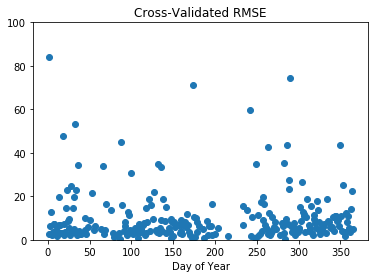

In [16]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

#This is one for mean
sqrtMSE = []
for i in range(365):
    df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
    df = df.dropna()
    X = df[['gus','temp','dir','slp']]
    y = df[['spd']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    lm = LinearRegression()
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    sqrtMSE.append(er)
    npSqrtMSE[i] = er

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)
firstMedRMSE = medSqrtMSE

print("Average RMSE: ",avgSqrtMSE)
print()
print("Medinan RMSE: ", medSqrtMSE)

#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)
plt.title("Cross-Validated RMSE")
plt.xlabel("Day of Year")
#plt.ylabel("RMSE")
plt.ylim(0,100)
plt.show()

### Right out of the box we see median RMSE of 6.50. We'll throw some polynomial features at it now to see if it affects performance...

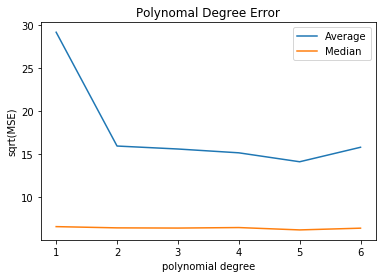

In [9]:
#Need to figure out what degree polynomial to use...
degreeList =[1,2,3,4,5,6]

avgList =[]
medList = []
for degree in degreeList:
    #This is one for mean
    sqrtMSE = []
    for i in range(365):
        df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
        df = df.dropna()
        X = df[['gus','temp','dir','slp']]
        y = df[['spd']]
        poly = PolynomialFeatures(degree = degree)
        X_ = poly.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_,y,test_size = 0.25, random_state = 1, shuffle = True)
        if len(X_train)<5:
            continue
        lm = LinearRegression()
        lm.fit(X = X_train, y = y_train)
        y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
        er = math.sqrt(mean_squared_error(y_pred,y_train))
        sqrtMSE.append(er)

    #Calculate average and median sqrt(MSE)
    sqrtMSE = np.array(sqrtMSE)
    avgSqrtMSE = np.mean(sqrtMSE)
    medSqrtMSE = np.median(sqrtMSE)

    avgList.append(avgSqrtMSE)
    medList.append(medSqrtMSE)
    

plt.plot(degreeList,avgList,label="Average")
plt.plot(degreeList,medList,label="Median")
plt.ylabel("sqrt(MSE)")
plt.xlabel("polynomial degree")
plt.title("Polynomal Degree Error")
plt.legend()
plt.show()

### It does not look like polynomial features improve the performance.  Below we'll try regularization and do a parameter sweep...

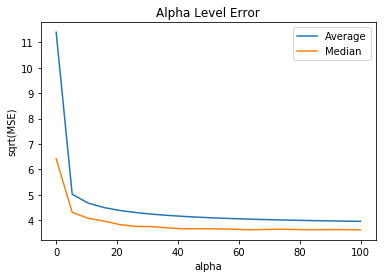

In [10]:
#Need to figure out what value of alpha to use...
alphaList = np.linspace(0.01,100,20)

avgList =[]
medList = []
for a in alphaList:
    #This is one for mean
    sqrtMSE = []
    for i in range(365):
        df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
        df = df.dropna()
        X = df[['gus','temp','dir','slp']]
        y = df[['spd']]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
        if len(X_train)<5:
            continue
        lm = Ridge(alpha = a)
        lm.fit(X = X_train, y = y_train)
        y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
        er = math.sqrt(mean_squared_error(y_pred,y_train))
        sqrtMSE.append(er)

    #Calculate average and median sqrt(MSE)
    sqrtMSE = np.array(sqrtMSE)
    avgSqrtMSE = np.mean(sqrtMSE)
    medSqrtMSE = np.median(sqrtMSE)

    avgList.append(avgSqrtMSE)
    medList.append(medSqrtMSE)
    

plt.plot(alphaList,avgList,label="Average")
plt.plot(alphaList,medList,label="Median")
plt.ylabel("sqrt(MSE)")
plt.xlabel("alpha")
plt.title("Alpha Level Error")
plt.legend()
plt.show()

### Looks like we're pretty leveled out by alpha = 60


Average RMSE:  4.05389211565

Medinan RMSE:  3.63307018286


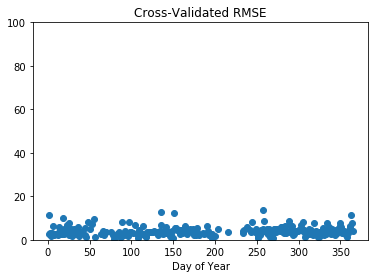

In [15]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

#This is one for mean
sqrtMSE = []
for i in range(365):
    df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
    df = df.dropna()
    X = df[['gus','temp','dir','slp']]
    y = df[['spd']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    lm = Ridge(alpha = 60)
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    sqrtMSE.append(er)
    npSqrtMSE[i] = er

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)
medRMSE = medSqrtMSE
print("Average RMSE: ",avgSqrtMSE)
print()
print("Medinan RMSE: ", medSqrtMSE)
#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)
plt.title("Cross-Validated RMSE")
plt.xlabel("Day of Year")
#plt.ylabel("RMSE")
plt.ylim(0,100)
plt.show()

In [17]:
(6.49652924027-3.64420025225)/6.49652924027
print(firstMedRMSE)
print(medRMSE)
print((firstMedRMSE - medRMSE)/firstMedRMSE)

6.69361850515
3.63307018286
0.457233754797


### We get a 43.9% decrease in error when we use regularization.  However, it seemed like the error was going down monotonically as we increased alpha.  This implies that a horizontal line might be a good fit for the data.  We'll test that theory with the mean of daily wind speeds, e.g., mean(y_test)

In [44]:
RMSE =[]
for i in range(365):
    df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
    df = df.dropna()
    X = df[['gus','temp','dir','slp']]
    y = df[['spd']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    #Create a vector that is equal to the mean value for every entry
    meany_train = np.zeros(len(y_train))
    for i in range(len(meany_train)):
        meany_train[i]= np.mean(y_train)
    rmse = math.sqrt(mean_squared_error(meany_train, y_train))
    RMSE.append(rmse)

RMSE = np.array(RMSE)
medControlRMSE = np.median(RMSE)
print("Median RMSE with mean(y_test) = ", medControlRMSE)
print((firstMedRMSE - medControlRMSE)/medControlRMSE)


Median RMSE with mean(y_test) =  2.76198953937
0.0230860715968


### Our theory was correct, the mean outperforms our model.  We get a 58.7% decrease in error when we simply look at the mean

### Now let's look at individual variable importance.  We'll normalize X so that it has zero mean and unit variance so that we can compare the coefficients.


Average RMSE:  3.32669583536

Medinan RMSE:  3.28897926238


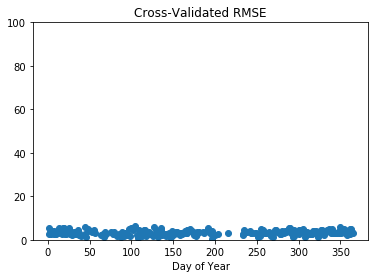


The average coefficient for gus is 0.1603330351388902
The average coefficient for temp is 0.022879342924261258
The average coefficient for dir is -0.026084541885543377
The average coefficient for slp is -0.025975297511691125
The average coefficient for intercept is 9.630112177293123
The means average to  9.62691774276

TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION
Average R^2 vale (test set):  -10.3162989557

Median R^2 value (test set):  -0.582353685566

Average RMSE (test set):  3.02478494575

Median RMSE (test set):  2.77465729887


In [47]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

CoeffDic = {}
for col_name in X.columns:
    CoeffDic[col_name] =[]
CoeffDic['intercept']=[]
#This is one for mean
sqrtMSE = []

means = [] # to hold the means of y_train

#These lists are for testing
testScore=[]
testRMSE = []
for i in range(365):
    df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
    df = df.dropna()
    X = df[['gus','temp','dir','slp']]
    scaledX = scale(X)
    y = df[['spd']]
    X_train, X_test, y_train, y_test = train_test_split(scaledX,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    lm = Ridge(alpha = 60)
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    sqrtMSE.append(er)
    npSqrtMSE[i] = er
    means.append(np.mean(y_train))
    for idx, col_name in enumerate(X.columns):
        CoeffDic[col_name].append(lm.coef_[0][idx])
        CoeffDic["intercept"].append(lm.intercept_[0])
        
    #below if for testing
    #the following was implemented after optimization
    score = lm.score(X=X_test, y = y_test)
    testScore.append(score)
    
    y_predict = lm.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_predict,y_test))
    testRMSE.append(rmse)

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)
medRMSE = medSqrtMSE
print("Average RMSE: ",avgSqrtMSE)
print()
print("Medinan RMSE: ", medSqrtMSE)
#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)
plt.title("Cross-Validated RMSE")
plt.xlabel("Day of Year")
#plt.ylabel("RMSE")
plt.ylim(0,100)
plt.show()
print()

for col_name in CoeffDic.keys():
    print("The average coefficient for {} is {}".format(col_name,np.mean(np.array(CoeffDic[col_name]))))
print("The means average to ", 
     np.mean(np.array(means)))

#below if for testing
testScore = np.array(testScore)
testRMSE = np.array(testRMSE)
scoreMean = np.mean(testScore)
rmseMean = np.mean(testRMSE)
scoreMed = np.median(testScore)
rmseMed = np.median(testRMSE)
print()
print("TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION")

print("Average R^2 vale (test set): ",scoreMean)
print()
print("Median R^2 value (test set): ",scoreMed)
print()
print("Average RMSE (test set): ", rmseMean)
print()
print("Median RMSE (test set): ", rmseMed)

# Just as we expected, we could increase alpha even more and the model would approach the mean, e.g., our model sucks!!

## **-------TEST VALUES AB0VE---------

In [23]:
print(firstMedRMSE)
print(medRMSE)
print((firstMedRMSE - medRMSE)/firstMedRMSE)

6.69361850515
3.28897926238
0.508639570682


### Looks Like gust is the only significant coefficient in our model.  Let's do a regression with only gust

Average RMSE:  3.04841191327

Medinan RMSE:  2.82575302762


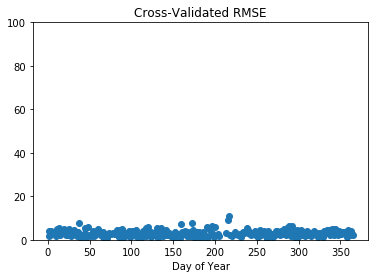

In [36]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

#This is one for mean
sqrtMSE = []
for i in range(365):
    df = dayOfYrDic[i+1][['gus','spd']]
    df = df.dropna()
    X = df[['gus']]
    y = df[['spd']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    lm = LinearRegression()
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    sqrtMSE.append(er)
    npSqrtMSE[i] = er

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)
firstMedRMSE = medSqrtMSE

print("Average RMSE: ",avgSqrtMSE)
print()
print("Medinan RMSE: ", medSqrtMSE)

#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)
plt.title("Cross-Validated RMSE")
plt.xlabel("Day of Year")
#plt.ylabel("RMSE")
plt.ylim(0,100)
plt.show()

### Interesting, we get a much lower initial error if we just use gust

### Again, we'll do a parameter sweep to find the best alpha for our ridge regression

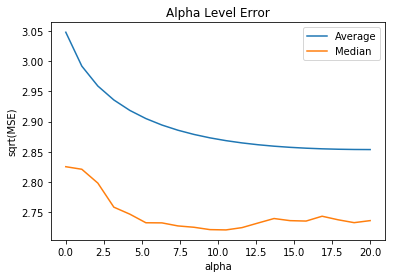

In [38]:
#Need to figure out what value of alpha to use...
alphaList = np.linspace(0.01,20,20)

avgList =[]
medList = []
for a in alphaList:
    #This is one for mean
    sqrtMSE = []
    for i in range(365):
        df = dayOfYrDic[i+1][['gus','spd']]
        df = df.dropna()
        X = df[['gus']]
        y = df[['spd']]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
        if len(X_train)<5:
            continue
        lm = Ridge(alpha = a)
        lm.fit(X = X_train, y = y_train)
        y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
        er = math.sqrt(mean_squared_error(y_pred,y_train))
        sqrtMSE.append(er)

    #Calculate average and median sqrt(MSE)
    sqrtMSE = np.array(sqrtMSE)
    avgSqrtMSE = np.mean(sqrtMSE)
    medSqrtMSE = np.median(sqrtMSE)

    avgList.append(avgSqrtMSE)
    medList.append(medSqrtMSE)
    

plt.plot(alphaList,avgList,label="Average")
plt.plot(alphaList,medList,label="Median")
plt.ylabel("sqrt(MSE)")
plt.xlabel("alpha")
plt.title("Alpha Level Error")
plt.legend()
plt.show()

### Looks like our optimal alpha value is about 10

Average RMSE:  2.87080529006

Medinan RMSE:  2.72015364202


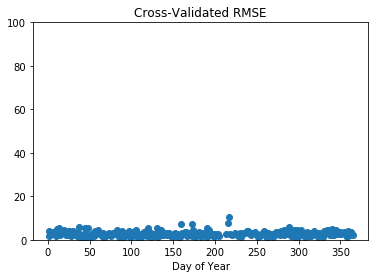


Median RMSE =  2.72015364202
% improvement with regularization:  0.0388211106789

TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION
Average R^2 vale (test set):  -71.1303681333

Median R^2 value (test set):  -0.357640235955

Average RMSE (test set):  2.72404197455

Median RMSE (test set):  2.52294601181


In [48]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

#This is one for mean
sqrtMSE = []

#These lists are for testing
testScore=[]
testRMSE = []
for i in range(365):
    df = dayOfYrDic[i+1][['gus','spd']]
    df = df.dropna()
    X = df[['gus']]
    y = df[['spd']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    lm = Ridge(alpha = 10)
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    sqrtMSE.append(er)
    npSqrtMSE[i] = er

    #below if for testing
    #the following was implemented after optimization
    score = lm.score(X=X_test, y = y_test)
    testScore.append(score)
    
    y_predict = lm.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_predict,y_test))
    testRMSE.append(rmse)

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)
medRMSE = medSqrtMSE
print("Average RMSE: ",avgSqrtMSE)
print()
print("Medinan RMSE: ", medSqrtMSE)
#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)
plt.title("Cross-Validated RMSE")
plt.xlabel("Day of Year")
#plt.ylabel("RMSE")
plt.ylim(0,100)
plt.show()
print()
print("Median RMSE = ",medRMSE)
print("% improvement with regularization: ",
     (firstMedRMSE - medRMSE)/medRMSE)

print()
#below if for testing
testScore = np.array(testScore)
testRMSE = np.array(testRMSE)
scoreMean = np.mean(testScore)
rmseMean = np.mean(testRMSE)
scoreMed = np.median(testScore)
rmseMed = np.median(testRMSE)
print("TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION")

print("Average R^2 vale (test set): ",scoreMean)
print()
print("Median R^2 value (test set): ",scoreMed)
print()
print("Average RMSE (test set): ", rmseMean)
print()
print("Median RMSE (test set): ", rmseMed)

### We get a 3.89% improvement with regularization (interesting...)

### Again, we'll compare our model to the mean(y_train)

# **----------TEST VALUES ABOVE----------

In [41]:
RMSE =[]
for i in range(365):
    df = dayOfYrDic[i+1][['gus','spd']]
    df = df.dropna()
    X = df[['gus']]
    y = df[['spd']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    #Create a vector that is equal to the mean value for every entry
    meany_train = np.zeros(len(y_train))
    for i in range(len(meany_train)):
        meany_train[i]= np.mean(y_train)
    rmse = math.sqrt(mean_squared_error(meany_train, y_train))
    RMSE.append(rmse)

RMSE = np.array(RMSE)
medControlRMSE = np.median(RMSE)
print("Median RMSE with mean(y_test) = ", medControlRMSE)
print((firstMedRMSE - medControlRMSE)/medControlRMSE)


Median RMSE with mean(y_test) =  2.79352550123
0.0115365069605


### we only get a 1.1% improvement with using the mean, thus our model is a little better than the mean!  


### Amazing, we can use gust to predict wind!!

# Below we'll try to predict direction

Average RMSE:  912.939267584

Medinan RMSE:  202.924609667


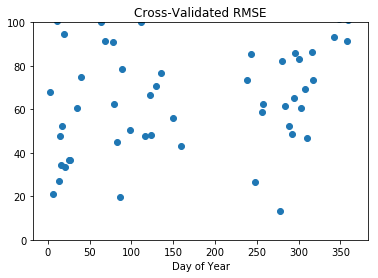

In [67]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

#This is one for mean
sqrtMSE = []
for i in range(365):
    df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
    df = df.dropna()
    X = df[['gus','temp','spd','slp']]
    y = df[['dir']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    lm = LinearRegression()
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    sqrtMSE.append(er)
    npSqrtMSE[i] = er

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)
firstMedRMSE = medSqrtMSE

print("Average RMSE: ",avgSqrtMSE)
print()
print("Medinan RMSE: ", medSqrtMSE)

#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)
plt.title("Cross-Validated RMSE")
plt.xlabel("Day of Year")
#plt.ylabel("RMSE")
plt.ylim(0,100)
plt.show()

### Right out of the box we get a huge error, implying that the direction will be very hard to predict!!!

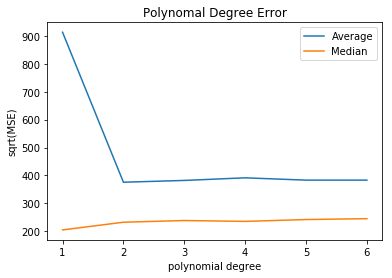

In [50]:
#Need to figure out what degree polynomial to use...
degreeList =[1,2,3,4,5,6]

avgList =[]
medList = []
for degree in degreeList:
    #This is one for mean
    sqrtMSE = []
    for i in range(365):
        df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
        df = df.dropna()
        X = df[['gus','temp','spd','slp']]
        y = df[['dir']]
        poly = PolynomialFeatures(degree = degree)
        X_ = poly.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_,y,test_size = 0.25, random_state = 1, shuffle = True)
        if len(X_train)<5:
            continue
        lm = LinearRegression()
        lm.fit(X = X_train, y = y_train)
        y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
        er = math.sqrt(mean_squared_error(y_pred,y_train))
        sqrtMSE.append(er)

    #Calculate average and median sqrt(MSE)
    sqrtMSE = np.array(sqrtMSE)
    avgSqrtMSE = np.mean(sqrtMSE)
    medSqrtMSE = np.median(sqrtMSE)

    avgList.append(avgSqrtMSE)
    medList.append(medSqrtMSE)
    

plt.plot(degreeList,avgList,label="Average")
plt.plot(degreeList,medList,label="Median")
plt.ylabel("sqrt(MSE)")
plt.xlabel("polynomial degree")
plt.title("Polynomal Degree Error")
plt.legend()
plt.show()

### Looks like polynomial features don't help too much here...

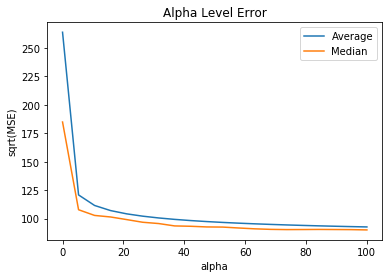

In [55]:
#Need to figure out what value of alpha to use...
alphaList = np.linspace(0.01,100,20)

avgList =[]
medList = []
for a in alphaList:
    #This is one for mean
    sqrtMSE = []
    for i in range(365):
        df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
        df = df.dropna()
        X = df[['gus','temp','spd','slp']]
        y = df[['dir']]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
        if len(X_train)<5:
            continue
        lm = Ridge(alpha = a)
        lm.fit(X = X_train, y = y_train)
        y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
        er = math.sqrt(mean_squared_error(y_pred,y_train))
        sqrtMSE.append(er)

    #Calculate average and median sqrt(MSE)
    sqrtMSE = np.array(sqrtMSE)
    avgSqrtMSE = np.mean(sqrtMSE)
    medSqrtMSE = np.median(sqrtMSE)

    avgList.append(avgSqrtMSE)
    medList.append(medSqrtMSE)
    

plt.plot(alphaList,avgList,label="Average")
plt.plot(alphaList,medList,label="Median")
plt.ylabel("sqrt(MSE)")
plt.xlabel("alpha")
plt.title("Alpha Level Error")
plt.legend()
plt.show()

### Same story as above




Average RMSE:  85.6044673438

Medinan RMSE:  85.2353866577
%decrease in median RMSE is  0.579965255088


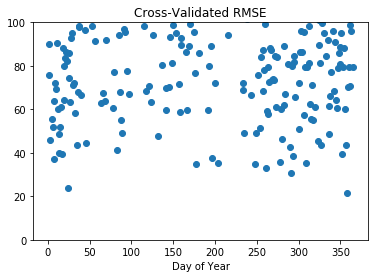


The average coefficient for gus is 0.3589907159100876
The average coefficient for temp is -0.21341455232245582
The average coefficient for spd is -0.3932366589448517
The average coefficient for slp is -0.3204992141427942
The average coefficient for intercept is 208.80462918874977
The means average to  208.798471433

TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION
Average R^2 vale (test set):  -158.161854776

Median R^2 value (test set):  -0.973527464704

Average RMSE (test set):  82.2924355934

Median RMSE (test set):  81.8670772667


In [68]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

CoeffDic = {}
for col_name in X.columns:
    CoeffDic[col_name] =[]
CoeffDic['intercept']=[]
#This is one for mean
sqrtMSE = []

means = [] # to hold the means of y_train

#These lists are for testing
testScore=[]
testRMSE = []
for i in range(365):
    df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
    df = df.dropna()
    X = df[['gus','temp','spd','slp']]
    scaledX = scale(X)
    y = df[['dir']]
    X_train, X_test, y_train, y_test = train_test_split(scaledX,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    lm = Ridge(alpha = 100)
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    sqrtMSE.append(er)
    npSqrtMSE[i] = er
    means.append(np.mean(y_train))
    for idx, col_name in enumerate(X.columns):
        CoeffDic[col_name].append(lm.coef_[0][idx])
        CoeffDic["intercept"].append(lm.intercept_[0])
        
    #below if for testing
    #the following was implemented after optimization
    score = lm.score(X=X_test, y = y_test)
    testScore.append(score)
    
    y_predict = lm.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_predict,y_test))
    testRMSE.append(rmse)

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)
medRMSE = medSqrtMSE
print("Average RMSE: ",avgSqrtMSE)
print()
print("Medinan RMSE: ", medSqrtMSE)

print("%decrease in median RMSE is ",
     (firstMedRMSE - medRMSE)/firstMedRMSE)
#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)
plt.title("Cross-Validated RMSE")
plt.xlabel("Day of Year")
#plt.ylabel("RMSE")
plt.ylim(0,100)
plt.show()
print()

for col_name in CoeffDic.keys():
    print("The average coefficient for {} is {}".format(col_name,np.mean(np.array(CoeffDic[col_name]))))
print("The means average to ", 
     np.mean(np.array(means)))

#below if for testing
testScore = np.array(testScore)
testRMSE = np.array(testRMSE)
scoreMean = np.mean(testScore)
rmseMean = np.mean(testRMSE)
scoreMed = np.median(testScore)
rmseMed = np.median(testRMSE)
print()
print("TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION")

print("Average R^2 vale (test set): ",scoreMean)
print()
print("Median R^2 value (test set): ",scoreMed)
print()
print("Average RMSE (test set): ", rmseMean)
print()
print("Median RMSE (test set): ", rmseMed)

## ------------Test Values Above---------------

In [69]:
RMSE =[]
for i in range(365):
    df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
    df = df.dropna()
    X = df[['gus','temp','spd','slp']]
    y = df[['dir']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    #Create a vector that is equal to the mean value for every entry
    meany_train = np.zeros(len(y_train))
    for i in range(len(meany_train)):
        meany_train[i]= np.mean(y_train)
    rmse = math.sqrt(mean_squared_error(meany_train, y_train))
    RMSE.append(rmse)

RMSE = np.array(RMSE)
medControlRMSE = np.median(RMSE)
print("Median RMSE with mean(y_test) = ", medControlRMSE)
print((firstMedRMSE - medControlRMSE)/medControlRMSE)


Median RMSE with mean(y_test) =  71.5749957141
1.83513268345


### Looks like the crappy model is using all of coefficients, so we'll try our individual features below

### Let's use gust to start with

Average RMSE:  102.018783436

Medinan RMSE:  94.0310559958


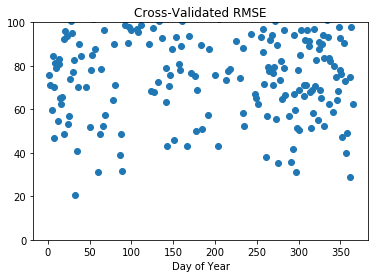

In [54]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

#This is one for mean
sqrtMSE = []
for i in range(365):
    df = dayOfYrDic[i+1][['gus','dir']]
    df = df.dropna()
    X = df[['gus']]
    y = df[['dir']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    lm = LinearRegression()
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    sqrtMSE.append(er)
    npSqrtMSE[i] = er

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)
firstMedRMSE = medSqrtMSE

print("Average RMSE: ",avgSqrtMSE)
print()
print("Medinan RMSE: ", medSqrtMSE)

#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)
plt.title("Cross-Validated RMSE")
plt.xlabel("Day of Year")
#plt.ylabel("RMSE")
plt.ylim(0,100)
plt.show()

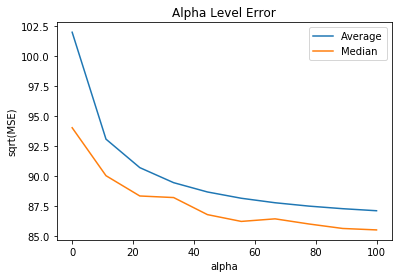

In [63]:
#Need to figure out what value of alpha to use...
alphaList = np.linspace(0.01,100,10)

avgList =[]
medList = []
for a in alphaList:
    #This is one for mean
    sqrtMSE = []
    for i in range(365):
        df = dayOfYrDic[i+1][['gus','dir']]
        df = df.dropna()
        X = df[['gus']]
        y = df[['dir']]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
        if len(X_train)<5:
            continue
        lm = Ridge(alpha = a)
        lm.fit(X = X_train, y = y_train)
        y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
        er = math.sqrt(mean_squared_error(y_pred,y_train))
        sqrtMSE.append(er)

    #Calculate average and median sqrt(MSE)
    sqrtMSE = np.array(sqrtMSE)
    avgSqrtMSE = np.mean(sqrtMSE)
    medSqrtMSE = np.median(sqrtMSE)

    avgList.append(avgSqrtMSE)
    medList.append(medSqrtMSE)
    

plt.plot(alphaList,avgList,label="Average")
plt.plot(alphaList,medList,label="Median")
plt.ylabel("sqrt(MSE)")
plt.xlabel("alpha")
plt.title("Alpha Level Error")
plt.legend()
plt.show()

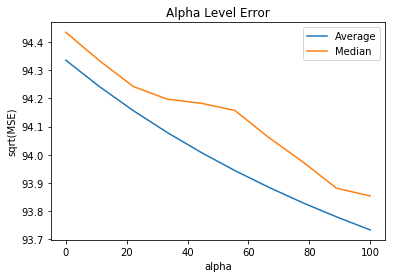

In [64]:
#Need to figure out what value of alpha to use...
alphaList = np.linspace(0.01,100,10)

avgList =[]
medList = []
for a in alphaList:
    #This is one for mean
    sqrtMSE = []
    for i in range(365):
        df = dayOfYrDic[i+1][['spd','dir']]
        df = df.dropna()
        X = df[['spd']]
        y = df[['dir']]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
        if len(X_train)<5:
            continue
        lm = Ridge(alpha = a)
        lm.fit(X = X_train, y = y_train)
        y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
        er = math.sqrt(mean_squared_error(y_pred,y_train))
        sqrtMSE.append(er)

    #Calculate average and median sqrt(MSE)
    sqrtMSE = np.array(sqrtMSE)
    avgSqrtMSE = np.mean(sqrtMSE)
    medSqrtMSE = np.median(sqrtMSE)

    avgList.append(avgSqrtMSE)
    medList.append(medSqrtMSE)
    

plt.plot(alphaList,avgList,label="Average")
plt.plot(alphaList,medList,label="Median")
plt.ylabel("sqrt(MSE)")
plt.xlabel("alpha")
plt.title("Alpha Level Error")
plt.legend()
plt.show()

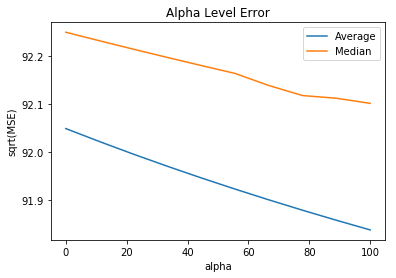

In [65]:
#Need to figure out what value of alpha to use...
alphaList = np.linspace(0.01,100,10)

avgList =[]
medList = []
for a in alphaList:
    #This is one for mean
    sqrtMSE = []
    for i in range(365):
        df = dayOfYrDic[i+1][['temp','dir']]
        df = df.dropna()
        X = df[['temp']]
        y = df[['dir']]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
        if len(X_train)<5:
            continue
        lm = Ridge(alpha = a)
        lm.fit(X = X_train, y = y_train)
        y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
        er = math.sqrt(mean_squared_error(y_pred,y_train))
        sqrtMSE.append(er)

    #Calculate average and median sqrt(MSE)
    sqrtMSE = np.array(sqrtMSE)
    avgSqrtMSE = np.mean(sqrtMSE)
    medSqrtMSE = np.median(sqrtMSE)

    avgList.append(avgSqrtMSE)
    medList.append(medSqrtMSE)
    

plt.plot(alphaList,avgList,label="Average")
plt.plot(alphaList,medList,label="Median")
plt.ylabel("sqrt(MSE)")
plt.xlabel("alpha")
plt.title("Alpha Level Error")
plt.legend()
plt.show()

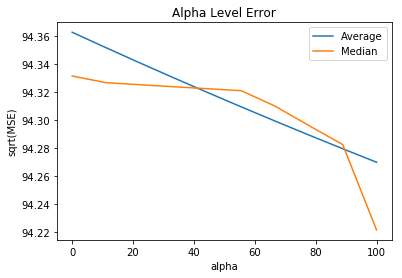

In [66]:
#Need to figure out what value of alpha to use...
alphaList = np.linspace(0.01,100,10)

avgList =[]
medList = []
for a in alphaList:
    #This is one for mean
    sqrtMSE = []
    for i in range(365):
        df = dayOfYrDic[i+1][['slp','dir']]
        df = df.dropna()
        X = df[['slp']]
        y = df[['dir']]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
        if len(X_train)<5:
            continue
        lm = Ridge(alpha = a)
        lm.fit(X = X_train, y = y_train)
        y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
        er = math.sqrt(mean_squared_error(y_pred,y_train))
        sqrtMSE.append(er)

    #Calculate average and median sqrt(MSE)
    sqrtMSE = np.array(sqrtMSE)
    avgSqrtMSE = np.mean(sqrtMSE)
    medSqrtMSE = np.median(sqrtMSE)

    avgList.append(avgSqrtMSE)
    medList.append(medSqrtMSE)
    

plt.plot(alphaList,avgList,label="Average")
plt.plot(alphaList,medList,label="Median")
plt.ylabel("sqrt(MSE)")
plt.xlabel("alpha")
plt.title("Alpha Level Error")
plt.legend()
plt.show()